# Recency Frequency Monetary Value

One of the most common methods for companies to segment their customers is a value-based approach.

The simplest and most used method is the RFM.

RFM stands for the three dimensions:

- Recency – How recently did the customer purchase?
- Frequency – How often do they purchase?
- Monetary Value – How much do they spend?

### In this project we will use this method to analyze the customer value of an online store.


In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('online_shoppers.csv', encoding= 'unicode_escape').dropna()

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Preparation


In [4]:
#creating sales column
data['Sales']= data['Quantity']*data['UnitPrice']

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [6]:
# date -tranform 
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


# get last date available
sanpshot_date = data['InvoiceDate'].max() + timedelta(days=1)

In [7]:
sanpshot_date

Timestamp('2011-12-10 12:50:00')

In [8]:
# aggregate on customer level
df = data.groupby('CustomerID').agg({'InvoiceNo':'count', 'Sales':'sum', 'InvoiceDate':lambda x: (sanpshot_date - x.max()).days})

In [9]:
df

,InvoiceNo,Sales,InvoiceDate
CustomerID,,,
12346.0,2,0.00,326
12347.0,182,4310.00,2
12348.0,31,1797.24,75
12349.0,73,1757.55,19
12350.0,17,334.40,310
...,...,...,...
18280.0,10,180.60,278
18281.0,7,80.82,181
18282.0,13,176.60,8


In [10]:
# Create basket (average spending per order)
df['Monetary'] = df['Sales']/df['InvoiceNo']

In [11]:
df.head()

,InvoiceNo,Sales,InvoiceDate,Monetary
CustomerID,,,,
12346.0,2,0.00,326,0.000000
12347.0,182,4310.00,2,23.681319
12348.0,31,1797.24,75,57.975484
12349.0,73,1757.55,19,24.076027
12350.0,17,334.40,310,19.670588


In [12]:
df = df.drop(columns='Sales', axis=1)


In [13]:
df.columns = ['Frequency', 'Recency', 'Monetary']

In [14]:
df.head()

,Frequency,Recency,Monetary
CustomerID,,,
12346.0,2,326,0.000000
12347.0,182,2,23.681319
12348.0,31,75,57.975484
12349.0,73,19,24.076027
12350.0,17,310,19.670588


In this first step we calculated the metrics that help us answer the questions we asked ourselves at the beginning of the project. The only thing to note is that Monetary Value I considered only the Basket that is the everage purchase value for each customer.

# Segment the customers

In this phase of the project I will proceed to segment the customers into 4 groups. So for each of the three dimensions (R, F, M) we will divide the customers into 4 quantiles and assign a point ranging from 1 to 4 for each quantile.

For frequency and monetary value, a score of 1 will be assigned to the 25% of customers who buy less frequently and spend less. 2 and 3 will be assigned to the second and third quartiles. While a score of 4 will be assigned to the top 25%.

For recency, the approach is similar but we have to give a score of 4 to 25% of those who bought more recently, 1 to those who bought less recently.

In [15]:
df['F'] = pd.qcut(df['Frequency'], 4, labels=range(1, 5,1))

In [16]:
df.head()

,Frequency,Recency,Monetary,F
CustomerID,,,,
12346.0,2,326,0.000000,1
12347.0,182,2,23.681319,4
12348.0,31,75,57.975484,2
12349.0,73,19,24.076027,3
12350.0,17,310,19.670588,1


In [17]:
df['M'] = pd.qcut(df['Monetary'], 4, labels=range(1, 5,1))

In [18]:
df['R'] = pd.qcut(df['Recency'], 4, labels=range(4, 0,-1))

## We can now calculate the RFM score by simply adding up the scores received for each dimension.

In [19]:
# RFM score
df['RFM'] = df[['R', 'F', 'M']].sum(axis=1)

In [20]:
df.head()

,Frequency,Recency,Monetary,F,M,R,RFM
CustomerID,,,,,,,
12346.0,2,326,0.000000,1,1,1,3
12347.0,182,2,23.681319,4,4,4,12
12348.0,31,75,57.975484,2,4,2,8
12349.0,73,19,24.076027,3,4,3,10
12350.0,17,310,19.670588,1,3,1,5


We can now create the 4 customer segments to which we have given the following names:

- SuperStar: customers who have obtained a score higher than 10

- Future Champion: customers with a score between 8 and 10

- High Potential: customers with a score between 6 and 7

- Low Relevance: for customers who have obtained a score lower than 5

In [21]:
def rfm_segment(df):
    if df['RFM'] >=11:
        return 'SuperStar'
    elif (df['RFM'] >= 8) and (df['RFM'] < 11):
        return 'Future Champion'
    elif (df['RFM'] >= 6) and (df['RFM'] < 8):
        return 'High Potential'
    else:
        return 'Low Relevance'

In [22]:
df['RFM_level'] = df.apply(rfm_segment, axis=1)

In [23]:
df.head()

,Frequency,Recency,Monetary,F,M,R,RFM,RFM_level
CustomerID,,,,,,,,
12346.0,2,326,0.000000,1,1,1,3,Low Relevance
12347.0,182,2,23.681319,4,4,4,12,SuperStar
12348.0,31,75,57.975484,2,4,2,8,Future Champion
12349.0,73,19,24.076027,3,4,3,10,Future Champion
12350.0,17,310,19.670588,1,3,1,5,Low Relevance


**It may be interesting to see the number of customers in each group and what the average is for recency, frequency and monetary value for each of the segments.**

<AxesSubplot:>

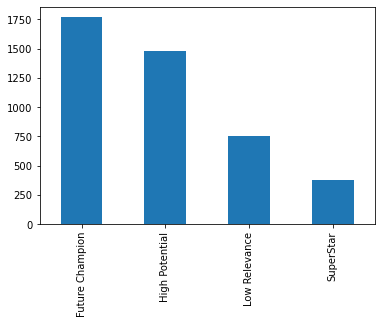

In [24]:
df['RFM_level'].value_counts().plot(kind='bar')

In [25]:
df.groupby('RFM_level').agg({'Frequency':'mean', 'Recency':'mean', 'Monetary':['mean', 'count']})

Frequency     Recency   Monetary      
                       mean        mean       mean count
RFM_level                                               
Future Champion  135.835973   32.007919  30.169670  1768
High Potential    39.213947  118.708869  38.033024  1477
Low Relevance     22.811421  221.483400  -0.586430   753
SuperStar        244.852941    9.973262  45.483949   374